In [1]:
from IPython.display import Markdown

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("https://github.com/mlefkir/beauxgraphs/raw/main/beautifulgraphs_colblind.mplstyle")

# Effects of the numerical Fourier Transform

Here we show the effects of computing the autocovariance function using a numerical Fourier transform. We will show these effects using functions where we know the analytical Fourier Transform. Which are the exponential and squared exponential autocovariance functions.

|  | Autocovariance $R(\tau)$ | Power spectrum $\mathcal{P}(f)$ |
| --- | ----------- | -- |
| Exponential | $\dfrac{A}{2\gamma} \exp{(-\|\tau\|\gamma)}$ | $\dfrac{A}{\gamma^2 +4\pi^2 f^2}$ |
| Squared exponential | $A\exp{(-2 \pi^2 \tau^2 \sigma^2)}$ | $\dfrac{A}{\sqrt{2\pi}\sigma}$ $\exp\left(-\dfrac{f^2}{2\sigma^2} \right)$ |

## Squared Exponential

First, we define the autocovariance function and its Fourier transform, i.e. the power spectrum.

In [2]:
def SE_ACV(t, A,sigma):
    return A * np.exp( -2 * np.pi**2 * sigma**2 * t**2 )

def SE_PSD(f, A,sigma):
    return A / (np.sqrt(2*np.pi) * sigma ) * np.exp( - 0.5 * f**2 / sigma**2 )

We generate a grid of frequencies from $0$ to $f_N$ with a spacing $\delta f=f_0$. The power spectrum will be of length $N$.

In [3]:
f0 = 1.13e-4
df = f0 
fN = 5. # max frequency
# grid of frequencies, from 0 to fend-df with step size df
f = np.arange(0,fN,df)
# number of points in the psd including the zeroth freq
N = len(f)
# define the parameters of the psd
A , sigma = 1 , 1500*f0

P = SE_PSD(f,A,sigma)

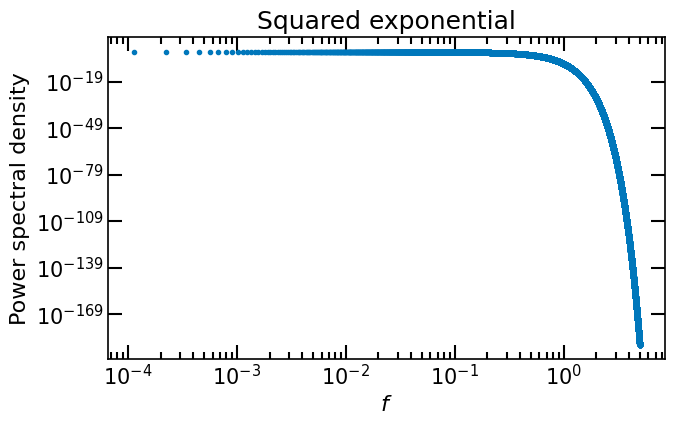

In [4]:
fig,ax = plt.subplots(1,1,figsize=(7,4.5))
ax.plot(f,P,'.')
ax.set_xlabel(r'$f$')
ax.set_ylabel('Power spectral density')
ax.loglog()
ax.set_title("Squared exponential")
fig.tight_layout()

As we know the power spectrum is symmetric for negative frequencies, we can use the real inverse Fourier transform to compute the autocovariance function. 

We use the function [```np.fft.irfft```](https://numpy.org/doc/stable/reference/generated/numpy.fft.irfft.html) to compute the inverse Fourier transform. The discrete inverse Fourier transform returns a real array of length $2N-2$. Where ```x[0]``` is the autocovariance at $\tau=0$ and ```x[N-1]``` is the autocovariance at $\tau=\tau_\mathrm{max}$, after which the autocovariance is mirrored for negative lags.

To obtain the true autocovariance function we divide the result by the sampling frequency $\delta f$.

In [5]:
tmax = 0.5 / df 
dt = 1/df/(N-1)/2

t = np.arange(0,tmax+dt,dt)

R_theo = SE_ACV(t,A,sigma) # theoretical inverse FT of the lorentzian

# compute the IFFT, with a normalisation factor 1/M, M=2*(len(y)-1)
R_dift = np.fft.irfft(P) 
assert (R_dift[1:N-1]-np.flip(R_dift[N:])<np.finfo(float).eps).all(), "The IRFFT did not return a mirrored ACV"
R_num = R_dift[:N]/dt

We can see that in the case of the squared exponential autocovariance function, the numerical Fourier transform is exact within the numerical precision.

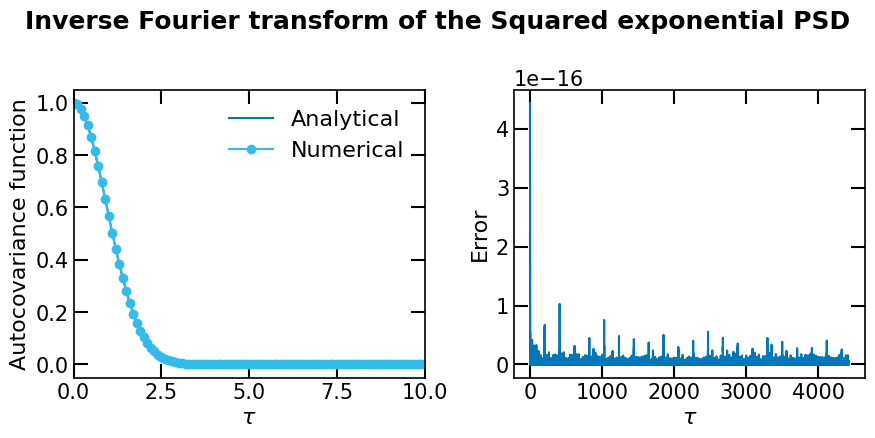

In [6]:
fig,ax = plt.subplots(1,2,figsize=(9,4.5))
ax[0].plot(t,R_theo,label='Analytical')#,marker='s')
ax[0].plot( t, R_num,label='Numerical',marker='o')

ax[0].legend()
ax[0].set_xlim(-1e-5,10 )
ax[0].set_xlabel(r"$\tau$")
ax[0].set_ylabel(r"Autocovariance function")
ax[1].plot(t,np.abs(R_theo-R_num),label='|Error|')#,marker='s')

ax[1].set_xlabel(r"$\tau$")
ax[1].set_ylabel(r"Error")
fig.suptitle("Inverse Fourier transform of the Squared exponential PSD")
fig.tight_layout()

We can check the Fourier pairs properties of the autocovariance function and the power spectrum by comparing the sums.

In [10]:
print(f"P(0)        : {P[0]:1.5e}")
print(f'Sum of ACV    : {np.trapz(R_num)*dt*2:1.5e}')
print(f'Sum of ACVtheo: {np.trapz(R_theo)*dt*2:1.5e}')
print(f"-------Difference-------: {np.trapz(R_num)*2*dt-P[0]:1.5e}\n")

print(f'Sum of PSD: {np.trapz(P)*df*2:1.3e}')
print(f'ACVtheo[0]: {(R_theo[0]):1.3e}')
print(f'ACV[0]    : {R_num[0]:1.3e}')
print(f"-------Difference-------: {np.trapz(P)*2*df-R_num[0]:1.3e}\n")

P(0)        : 2.35364e+00
Sum of ACV    : 2.35364e+00
Sum of ACVtheo: 2.35364e+00
-------Difference-------: -8.88178e-16

Sum of PSD: 1.000e+00
ACVtheo[0]: 1.000e+00
ACV[0]    : 1.000e+00
-------Difference-------: -2.220e-16



## Exponential